In [ ]:
!pip install gymnasium

In [18]:
from train_game_env import TrainGameEnv

env = TrainGameEnv()
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

# Test it works
state = env.reset()
action = env.action_space.sample()  # Random action
next_state, reward, done, info = env.step(action)

print(f"State: {state}")
print(f"Reward: {reward}")
print(f"Done: {done}")
print(f"Info: {info}")

Action space: Discrete(3)
Observation space: Box([ 0.  0.  0. -1.  0.  0.], [inf inf 12.  1. 23. 59.], (6,), float32)
State: [100.   0.   0.   1.  16.   5.]
Reward: 101.04
Done: False
Info: {'alighted': 0, 'penalty_unused': 0.96, 'efficiency_ratio': 0.0}


In [26]:
# ===============================
# AGENT INSTANTIATIONS FOR TRAIN GAME
# ===============================

import numpy as np
import random
from collections import defaultdict

# For Actor-Critic
import torch
import torch.nn as nn
import torch.optim as optim

# ---- state discretizer for tabular agents ----
def discretize_state(state):
    # state: [capacity, onboard, station_idx, direction, hour, minute]
    # Convert to your original 5-dimensional state for compatibility
    cap, onboard, station_idx, direction, hour, minute = state
    cap_bin = int(cap // 100)    # bucket by 100s
    on_bin = int(onboard // 50)  # bucket by 50s
    dir_bin = 1 if direction >= 0 else 0
    hour_seg = int(hour // 4)    # 0..5 segments (4-hour blocks)
    return (cap_bin, on_bin, int(station_idx), dir_bin, hour_seg)

# Alternative: Use normalized state for neural networks
def normalize_state(state):
    """Normalize state for neural network agents"""
    cap, onboard, station_idx, direction, hour, minute = state
    return np.array([
        cap / 1000,              # Normalize capacity (assume max ~1000)
        onboard / 500,           # Normalize passengers (assume max ~500)
        station_idx / 12,        # Normalize station index
        (direction + 1) / 2,     # Convert -1/1 to 0/1
        hour / 23,               # Normalize hour
        minute / 59              # Normalize minute
    ], dtype=np.float32)

# ---- Monte Carlo Agent ----
class MonteCarloAgent:
    def __init__(self, n_actions=3, eps=0.1):
        self.n_actions = n_actions
        self.eps = eps
        self.Q = defaultdict(float)
        self.returns = defaultdict(list)

    def policy(self, state, greedy=False):
        ds = discretize_state(state)
        if (not greedy) and (random.random() < self.eps):
            return random.randint(0, self.n_actions-1)
        qvals = [self.Q[(ds,a)] for a in range(self.n_actions)]
        # If no Q-values, choose randomly
        if all(q == 0 for q in qvals):
            return random.randint(0, self.n_actions-1)
        return int(np.argmax(qvals))

    def update(self, episode):  # list of (state, action, reward)
        G = 0
        visited = set()
        for s, a, r in reversed(episode):
            G = r + G
            key = (tuple(discretize_state(s)), a)
            if key not in visited:
                visited.add(key)
                self.returns[key].append(G)
                self.Q[key] = np.mean(self.returns[key])

# ---- Q-Learning Agent ----
class QLearningAgent:
    def __init__(self, n_actions=3, alpha=0.1, gamma=0.99, eps=0.1):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.Q = defaultdict(float)

    def policy(self, state, greedy=False):
        ds = discretize_state(state)
        if (not greedy) and (random.random() < self.eps):
            return random.randint(0, self.n_actions-1)
        qvals = [self.Q[(ds,a)] for a in range(self.n_actions)]
        # If no Q-values, choose randomly
        if all(q == 0 for q in qvals):
            return random.randint(0, self.n_actions-1)
        return int(np.argmax(qvals))

    def update(self, s, a, r, s_next, done):
        ds = discretize_state(s)
        ds_next = discretize_state(s_next)
        
        if done:
            target = r
        else:
            best_next = max([self.Q[(ds_next, a2)] for a2 in range(self.n_actions)])
            target = r + self.gamma * best_next
            
        self.Q[(ds,a)] += self.alpha * (target - self.Q[(ds,a)])

# ---- Actor-Critic Agent ----
class ACNetwork(nn.Module):
    def __init__(self, state_dim=6, action_dim=3, hidden=128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.actor = nn.Linear(hidden, action_dim)
        self.critic = nn.Linear(hidden, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        policy = torch.softmax(self.actor(x), dim=-1)
        value = self.critic(x)
        return policy, value

class ActorCriticAgent:
    def __init__(self, state_dim=6, action_dim=3, lr=1e-3, gamma=0.99):
        self.net = ACNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.gamma = gamma
        self.state_dim = state_dim

    def policy(self, state):
        # Use normalized state for better training
        normalized_state = normalize_state(state)
        st = torch.FloatTensor(normalized_state).unsqueeze(0)
        probs, val = self.net(st)
        dist = torch.distributions.Categorical(probs)
        a = dist.sample()
        return a.item(), dist.log_prob(a), val

    def learn(self, trajectory):
        """Learn from a trajectory of (state, action, reward, next_state)"""
        if len(trajectory) == 0:
            return
            
        returns = []
        G = 0
        
        # Calculate returns
        for _, _, r, _ in reversed(trajectory):
            G = r + self.gamma * G
            returns.insert(0, G)
            
        returns = torch.tensor(returns, dtype=torch.float32)
        
        # Extract components from trajectory
        log_probs = []
        values = []
        
        for state, action_info, _, _ in trajectory:
            # action_info should be (action, log_prob, value)
            if len(action_info) == 3:
                _, log_prob, value = action_info
                log_probs.append(log_prob)
                values.append(value)
        
        if not log_probs:
            return
            
        log_probs = torch.stack(log_probs)
        values = torch.cat(values).squeeze()
        
        # Calculate advantages
        advantages = returns - values.detach()
        
        # Calculate losses
        actor_loss = -(log_probs * advantages).mean()
        critic_loss = nn.MSELoss()(values, returns)
        loss = actor_loss + 0.5 * critic_loss  # Weight critic loss
        
        # Update network
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=1.0)
        self.optimizer.step()

# ---- Training Helper Functions ----
def train_agent(env, agent, episodes=1000, max_steps=200):
    """Generic training function for any agent"""
    rewards_history = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        episode_data = []  # For Monte Carlo
        
        for step in range(max_steps):
            # Get action based on agent type
            if isinstance(agent, ActorCriticAgent):
                action, log_prob, value = agent.policy(state)
                action_info = (action, log_prob, value)
            else:
                action = agent.policy(state)
                action_info = action
            
            # Take step
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            
            # Update based on agent type
            if isinstance(agent, QLearningAgent):
                agent.update(state, action, reward, next_state, done)
            elif isinstance(agent, MonteCarloAgent):
                episode_data.append((state, action, reward))
            
            state = next_state
            
            if done:
                break
        
        # Post-episode updates
        if isinstance(agent, MonteCarloAgent):
            agent.update(episode_data)
        elif isinstance(agent, ActorCriticAgent):
            # For AC, we'd need to store the full trajectory
            pass
        
        rewards_history.append(total_reward)
        
        if episode % 100 == 0:
            avg_reward = np.mean(rewards_history[-100:])
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}")
    
    return rewards_history

# ---- Agent Testing Function ----
def test_agent(env, agent, episodes=10, render=False):
    """Test a trained agent"""
    total_scores = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        
        for step in range(200):  # max steps
            if isinstance(agent, ActorCriticAgent):
                action, _, _ = agent.policy(state)
            else:
                action = agent.policy(state, greedy=True)  # Use greedy policy
            
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            
            if render:
                env.render()
                print(f"Step: {step}, Action: {action}, Reward: {reward:.2f}")
            
            state = next_state
            if done:
                break
        
        final_score, _ = env.final_score()
        total_scores.append(final_score)
        print(f"Test Episode {episode}: Score = {final_score}/100, Total Reward = {total_reward:.2f}")
    
    return np.mean(total_scores)

In [29]:
# ===============================
# AGENT TRAINING (UPDATED)
# ===============================

import matplotlib.pyplot as plt
import numpy as np

def evaluate_policy_agent(agent, env_ctor, episodes=10):
    """Evaluate agent performance"""
    scores = []
    for _ in range(episodes):
        env = env_ctor()
        s = env.reset()
        done = False
        while not done:
            if isinstance(agent, ActorCriticAgent):
                a, _, _ = agent.policy(s)
            else:
                a = agent.policy(s, greedy=True)
            s, r, done, _ = env.step(a)
        norm, raw = env.final_score()
        scores.append(norm)
    return np.mean(scores), np.std(scores)

def train_mc(agent, env_ctor, episodes=300, max_steps_per_ep=200):
    """Train Monte Carlo agent"""
    eval_every = max(10, episodes//20)
    eval_scores = []
    for ep in range(episodes):
        env = env_ctor()
        state = env.reset()
        episode = []
        done = False
        steps = 0
        while not done and steps < max_steps_per_ep:
            a = agent.policy(state)
            next_state, reward, done, _ = env.step(a)
            episode.append((state, a, reward))
            state = next_state
            steps += 1
        agent.update(episode)
        if (ep+1) % eval_every == 0 or ep==episodes-1:
            mean_score, _ = evaluate_policy_agent(agent, env_ctor, episodes=6)
            eval_scores.append((ep+1, mean_score))
            print(f"MC Episode {ep+1}: Score = {mean_score:.1f}")
    return eval_scores

def train_q(agent, env_ctor, episodes=300, max_steps_per_ep=200):
    """Train Q-Learning agent"""
    eval_every = max(10, episodes//20)
    eval_scores = []
    for ep in range(episodes):
        env = env_ctor()
        s = env.reset()
        done = False
        steps = 0
        while not done and steps < max_steps_per_ep:
            a = agent.policy(s)
            s_next, r, done, _ = env.step(a)
            agent.update(s, a, r, s_next, done)  # Added done parameter
            s = s_next
            steps += 1
        if (ep+1) % eval_every == 0 or ep==episodes-1:
            mean_score, _ = evaluate_policy_agent(agent, env_ctor, episodes=6)
            eval_scores.append((ep+1, mean_score))
            print(f"QL Episode {ep+1}: Score = {mean_score:.1f}")
    return eval_scores

def train_ac(agent, env_ctor, episodes=300, max_steps_per_ep=200):
    """Train Actor-Critic agent"""
    eval_every = max(10, episodes//20)
    eval_scores = []
    for ep in range(episodes):
        env = env_ctor()
        s = env.reset()
        done = False
        steps = 0
        trajectory = []
        while not done and steps < max_steps_per_ep:
            a, logprob, val = agent.policy(s)
            s_next, r, done, _ = env.step(a)
            trajectory.append((s, (a, logprob, val), r, s_next))  # Store full info
            s = s_next
            steps += 1
        
        # Learn from trajectory
        if len(trajectory) > 0:
            agent.learn(trajectory)
            
        if (ep+1) % eval_every == 0 or ep==episodes-1:
            mean_score, _ = evaluate_policy_agent(agent, env_ctor, episodes=6)
            eval_scores.append((ep+1, mean_score))
            print(f"AC Episode {ep+1}: Score = {mean_score:.1f}")
    return eval_scores

Training Monte Carlo...
MC Episode 25: Score = 26.0
MC Episode 50: Score = 1.0
MC Episode 75: Score = 29.8
MC Episode 100: Score = 7.3
MC Episode 125: Score = 11.7
MC Episode 150: Score = 23.0
MC Episode 175: Score = 11.2
MC Episode 200: Score = 14.0
MC Episode 225: Score = 1.0
MC Episode 250: Score = 1.0
MC Episode 275: Score = 1.0
MC Episode 300: Score = 17.5
MC Episode 325: Score = 8.8
MC Episode 350: Score = 1.0
MC Episode 375: Score = 8.7
MC Episode 400: Score = 4.2
MC Episode 425: Score = 9.2
MC Episode 450: Score = 1.0
MC Episode 475: Score = 5.7
MC Episode 500: Score = 22.0

Training Q-Learning...
QL Episode 25: Score = 1.0
QL Episode 50: Score = 1.0
QL Episode 75: Score = 17.0
QL Episode 100: Score = 10.5
QL Episode 125: Score = 16.8
QL Episode 150: Score = 11.7
QL Episode 175: Score = 10.5
QL Episode 200: Score = 21.5
QL Episode 225: Score = 49.8
QL Episode 250: Score = 33.7
QL Episode 275: Score = 10.8
QL Episode 300: Score = 17.5
QL Episode 325: Score = 16.7
QL Episode 350:

c:\Users\Dhan Michea\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


AC Episode 25: Score = 1.0
AC Episode 50: Score = 1.0
AC Episode 75: Score = 18.2
AC Episode 100: Score = 79.5
AC Episode 125: Score = 78.5
AC Episode 150: Score = 35.5
AC Episode 175: Score = 60.2
AC Episode 200: Score = 60.8
AC Episode 225: Score = 48.3
AC Episode 250: Score = 57.3
AC Episode 275: Score = 55.8
AC Episode 300: Score = 68.5
AC Episode 325: Score = 63.7
AC Episode 350: Score = 69.8
AC Episode 375: Score = 78.0
AC Episode 400: Score = 92.7
AC Episode 425: Score = 87.8
AC Episode 450: Score = 87.8
AC Episode 475: Score = 85.8
AC Episode 500: Score = 89.5


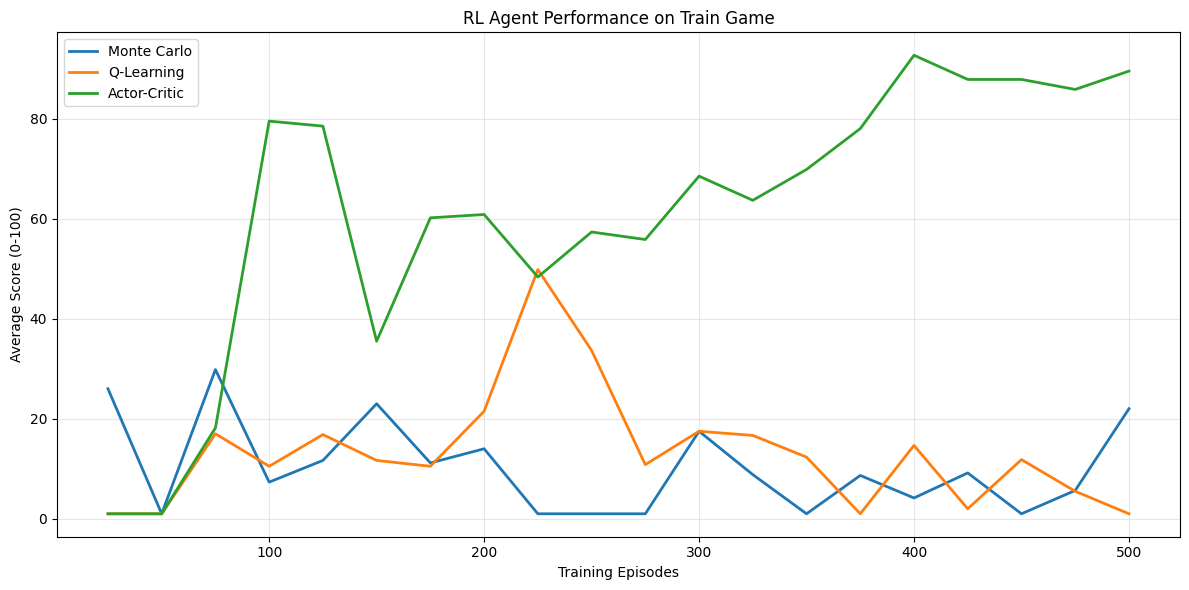


FINAL EVALUATION RESULTS

Monte Carlo:
  Average Score: 10.2 ± 19.6
  Average Total Reward: -180682.8
  Average Config Cost: 568.5

Q-Learning:
  Average Score: 13.1 ± 24.4
  Average Total Reward: -194657.4
  Average Config Cost: 553.0

Actor-Critic:
  Average Score: 86.9 ± 3.7
  Average Total Reward: 7621.8
  Average Config Cost: 0.0

LIVE PLAYTHROUGH DEMONSTRATIONS

Training completed! Use final_evaluation() for detailed metrics.


In [30]:
# ===============================
# AGENT TEST RUN (UPDATED)
# ===============================

import matplotlib.pyplot as plt
from functools import partial
import time

# Import your environment
from train_game_env import TrainGameEnv, draw_train

# Environment constructor for fresh envs
def env_ctor():
    return TrainGameEnv(seed=None, verbose=False)

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Instantiate agents with correct state dimensions
mc_agent = MonteCarloAgent(n_actions=3, eps=0.1)
q_agent = QLearningAgent(n_actions=3, alpha=0.1, gamma=0.99, eps=0.1)
ac_agent = ActorCriticAgent(state_dim=6, action_dim=3, lr=1e-3, gamma=0.99)  # Updated to 6D state

# Training parameters - reduced for testing
EPISODES = 500  # Reduced from 1000 for faster testing

print("Training Monte Carlo...")
mc_scores = train_mc(mc_agent, env_ctor, episodes=EPISODES)
print("\nTraining Q-Learning...")
q_scores = train_q(q_agent, env_ctor, episodes=EPISODES)
print("\nTraining Actor-Critic...")
ac_scores = train_ac(ac_agent, env_ctor, episodes=EPISODES)

# Convert training logs to X/Y for plotting
def to_xy(score_list):
    xs = [x for x, _ in score_list]
    ys = [y for _, y in score_list]
    return xs, ys

mc_x, mc_y = to_xy(mc_scores)
q_x, q_y = to_xy(q_scores)
ac_x, ac_y = to_xy(ac_scores)

# Plot learning curves
plt.figure(figsize=(12, 6))
plt.plot(mc_x, mc_y, label="Monte Carlo", linewidth=2)
plt.plot(q_x, q_y, label="Q-Learning", linewidth=2)
plt.plot(ac_x, ac_y, label="Actor-Critic", linewidth=2)
plt.xlabel("Training Episodes")
plt.ylabel("Average Score (0-100)")
plt.title("RL Agent Performance on Train Game")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Final evaluation with more detailed metrics
def final_evaluation(agents, env_ctor, episodes=10):
    """Comprehensive final evaluation"""
    print("\n" + "="*60)
    print("FINAL EVALUATION RESULTS")
    print("="*60)
    
    results = {}
    for name, agent in agents.items():
        scores = []
        total_rewards = []
        config_costs = []
        
        for ep in range(episodes):
            env = env_ctor()
            state = env.reset()
            total_reward = 0
            done = False
            
            while not done:
                if isinstance(agent, ActorCriticAgent):
                    action, _, _ = agent.policy(state)
                else:
                    action = agent.policy(state, greedy=True)
                
                state, reward, done, _ = env.step(action)
                total_reward += reward
            
            norm_score, raw_score = env.final_score()
            scores.append(norm_score)
            total_rewards.append(total_reward)
            config_costs.append(env.total_config_cost)
        
        results[name] = {
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
            'mean_reward': np.mean(total_rewards),
            'mean_config_cost': np.mean(config_costs)
        }
        
        print(f"\n{name}:")
        print(f"  Average Score: {results[name]['mean_score']:.1f} ± {results[name]['std_score']:.1f}")
        print(f"  Average Total Reward: {results[name]['mean_reward']:.1f}")
        print(f"  Average Config Cost: {results[name]['mean_config_cost']:.1f}")
    
    return results

# Run final evaluation
agents_dict = {
    'Monte Carlo': mc_agent,
    'Q-Learning': q_agent,
    'Actor-Critic': ac_agent
}

final_results = final_evaluation(agents_dict, env_ctor, episodes=10)

# Visual playthrough function
def rollout_and_print(agent, title, max_steps=50):
    env = env_ctor()
    state = env.reset()
    print("\n" + "="*50)
    print(f"LIVE PLAYTHROUGH — {title}")
    print("="*50)
    
    steps = 0
    total_reward = 0
    
    while (not env.done) and steps < max_steps:
        # Get action
        if isinstance(agent, ActorCriticAgent):
            action, _, _ = agent.policy(state)
        else:
            action = agent.policy(state, greedy=True)
        
        # Take step
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        
        # Display current state
        print(f"\nStep {steps + 1}:")
        draw_train(env)
        print(f"Action: {action} | Reward: {reward:.1f} | Total Reward: {total_reward:.1f}")
        print(f"Alighted: {info.get('alighted', 0)} | Efficiency: {info.get('efficiency_ratio', 0):.2f}")
        
        state = next_state
        steps += 1
        time.sleep(0.5)  # Slow down for readability
    
    # Final results
    norm, raw = env.final_score()
    print(f"\n🎯 FINAL RESULTS - {title}:")
    print(f"Normalized Score: {norm}/100")
    print(f"Raw Score: {raw:.1f}")
    print(f"Total Reward: {total_reward:.1f}")
    print(f"Configuration Cost: {env.total_config_cost:.1f}")
    print(f"Passengers Carried: {env.total_boarded}")
    print(f"Reason ended: {env.done_reason}")

# Show playthrough for each agent
print("\n" + "="*60)
print("LIVE PLAYTHROUGH DEMONSTRATIONS")
print("="*60)

# Uncomment to see live playthroughs (they take time)
# rollout_and_print(mc_agent, "Monte Carlo Agent")
# rollout_and_print(q_agent, "Q-Learning Agent") 
# rollout_and_print(ac_agent, "Actor-Critic Agent")

print("\nTraining completed! Use final_evaluation() for detailed metrics.")